# Package for ADDA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import argparse
import warnings

%matplotlib inline
warnings.filterwarnings(action='ignore')

# Parameters for ADDA

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch implementation of ADDA')

# Parameters for dataset and data loader
parser.add_argument('--data-root', default='data', type=str, help='Root directory of datasets')
parser.add_argument('--batch-size', default=128, type=int, help='Batch size of data loader')
parser.add_argument('--image-size', default=28, type=int, help='Image size of datasets')

# Parameters for optimizing models
parser.add_argument('--lr-src-enc', default=0.0001, type=float, help='Learning rate for source encoder and clssifier')
parser.add_argument('--lr-tgt-enc', default=0.00005, type=float, help='Learning rate for target encoder')
parser.add_argument('--lr-dis', default=0.001, type=float, help='Learning rate for discriminator')
parser.add_argument('--beta1', default=0.5, type=float, help='Beta1 for Adam optimizer')
parser.add_argument('--beta2', default=0.9, type=float, help='Beta2 for Adam optimizer')

# Parameters for training models
parser.add_argument('--model-root', default='backup', type=str, help='Root directory of model parameters')
parser.add_argument('--epochs-pre', default=20, type=int, help='Number of epochs for pre-training')
parser.add_argument('--save-pre', default=10, type=int, help='Interval of saving models for pre-training')
parser.add_argument('--test-pre', default=10, type=int, help='Interval of testing models for pre-training')

parser.add_argument('--epochs-adapt', default=500, type=int, help='Number of epochs for adversarial adaptation')
parser.add_argument('--save-adapt', default=100, type=int, help='Interval of saving models for adversarial adaptation')

# Parameters for GPU
parser.add_argument('--gpu-num', default=0, type=int, help='GPU number')

# Parameters for saving plot
parser.add_argument('--img-root', default='img', type=str, help='Root directory of plots')

args = parser.parse_args('')

# Dataset and Data Loader for MNIST

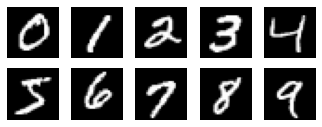

 - **Images** : Handwritten digits
 - **Labels** : 0 ~ 9
 - **Shape of Image** : 1 X 28 X 28
 - **Number of training set**: 60,000
 - **Number of test set** : 10,000

In [ ]:
def get_mnist(train=True):
    """ Get MNIST data loader """

    # Image pre-processing
    transform = transforms.Compose([transforms.Resize(args.image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1))])
    
    # MNIST dataset
    mnist_dataset = datasets.MNIST(root=args.data_root,
                                   train=train,
                                   transform=transform,
                                   download=True)
    
    # MNIST data loader
    mnist_loader = DataLoader(dataset=mnist_dataset,
                              batch_size=args.batch_size,
                              shuffle=True)
    
    return mnist_loader

## MNIST Visualization

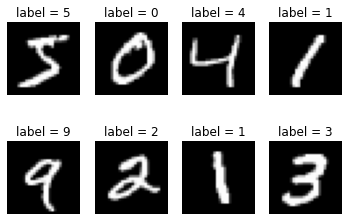

In [ ]:
mnist_loader = get_mnist()
fig, axes = plt.subplots(2, 4)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnist_loader.dataset.data[i], cmap='gray')
    ax.set(title='label = {}'.format(mnist_loader.dataset.targets[i]))
    ax.set_axis_off()

# Dataset and Data Loader for USPS

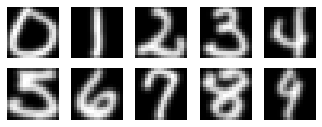

 - **Images** : Handwritten digits
 - **Labels** : 0 ~ 9
 - **Shape of Image** : 1 X 16 X 16
 - **Number of training set**: 7,291
 - **Number of test set** : 2,007

In [ ]:
def get_usps(train=True):
    """ Get USPS data loader """

    # Image pre-processing
    transform = transforms.Compose([transforms.Resize(args.image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.2469,), (0.2989,)),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1))])
    
    # USPS dataset
    usps_dataset = datasets.USPS(root=args.data_root,
                                 train=train,
                                 transform=transform,
                                 download=True)
    
    # USPS data loader
    usps_loader = DataLoader(dataset=usps_dataset,
                             batch_size=args.batch_size,
                             shuffle=True)
    
    return usps_loader

## USPS Visualization

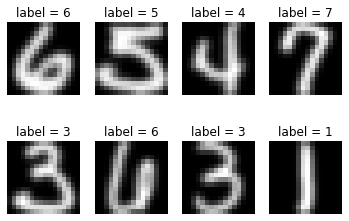

In [ ]:
mnist_loader = get_usps()
fig, axes = plt.subplots(2, 4)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnist_loader.dataset.data[i], cmap='gray')
    ax.set(title='label = {}'.format(mnist_loader.dataset.targets[i]))
    ax.set_axis_off()

# Models for ADDA

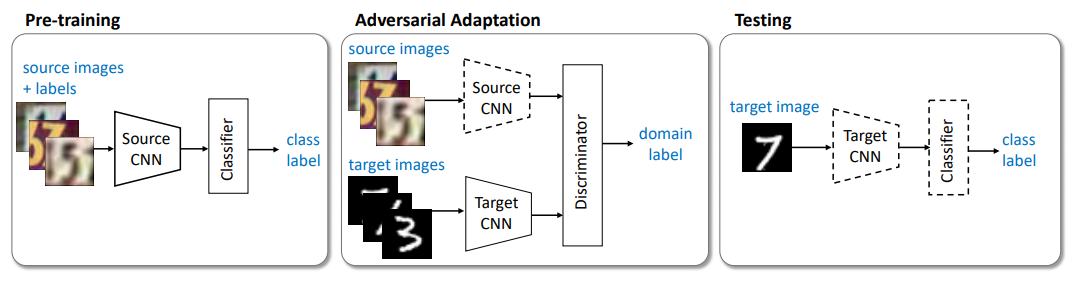

- **Encoder : CNN**

  - CNN $M$은 input image $x$로부터 feature vector $f$를 추출한다.
  - $f = M(x)$


- **Classifier : Classifier**

  - Classifier $C$는 feature vector $f$로부터 label $y$를 예측한다.
  - $y = C(f)$


- **Discriminator : Discriminator**
  
  - Discriminator $D$는 feature vector $f$로부터 domain label $d$를 분류한다.
  - $d = D(f)$

In [ ]:
class Encoder(nn.Module):
    """ Encoder for ADDA """

    def __init__(self):
        """ Initialize encoder """

        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            # 1st convolutional layer
            # Input  : [ 3 X 28 X 28]
            # Output : [20 X 12 X 12]
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            # 2nd convolutional layer
            # Input  : [20 X 12 X 12]
            # Output : [50 X  4 X  4] 
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        self.fc = nn.Linear(in_features=50 * 4 * 4, out_features=500)

    def forward(self, x):
        """ Forward the encoder """

        x = self.encoder(x)
        x = self.fc(x.view(-1, 50 * 4 * 4))
        return x


class Classifier(nn.Module):
    """ Classifier for ADDA """

    def __init__(self):
        """ Initialize classifier """

        super(Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=500, out_features=10)
        )

    def forward(self, x):
        """ Forward the classifier """

        x = self.classifier(x)
        return x


class Discriminator(nn.Module):
    """ Discriminator for ADDA """

    def __init__(self):
        """ Initialize discriminator """

        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(in_features=500, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=500),
            nn.ReLU(),
            nn.Linear(in_features=500, out_features=1)
        )

    def forward(self, x):
        """ Forward the discriminator """

        x = self.discriminator(x)
        return x

# Pre-training

**Forward Propagation**

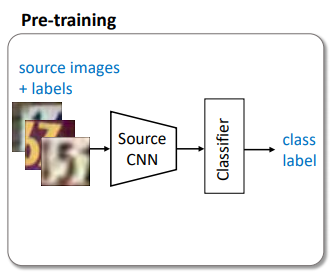 

  - Source dataset $(X_s, Y_s)$으로부터 class label을 제대로 예측할 수 있도록 source CNN $M_s$과 classifier $C$를 학습한다.


---

**Backpropagation**

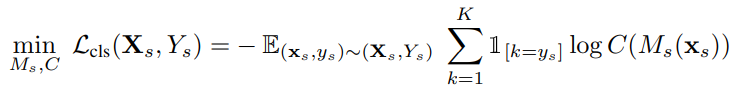

In [ ]:
def train_src(encoder, classifier, src_loader):
    """ Pre-train source encoder and classifier """

    # Setup criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=list(encoder.parameters()) + list(classifier.parameters()),
                           lr=args.lr_src_enc,
                           betas=(args.beta1, args.beta2))
    
    # Train model
    for epoch in range(1, args.epochs_pre + 1):
        encoder.train()
        classifier.train()

        num_data = 0
        total_acc = 0.0
        total_loss = 0.0

        for images, labels in src_loader:
            # Load images and labels to GPU
            images = load_gpu(images)
            labels = load_gpu(labels)

            # Predict labels and compute loss
            preds = classifier(encoder(images))
            loss = criterion(preds, labels)

            # Optimize models
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update total loss and accuracy
            num_data += len(labels)
            total_acc += (preds.max(1)[1] == labels).sum().item()
            total_loss += loss.item()

        total_acc = total_acc / num_data
        total_loss = total_loss / len(src_loader)

        # Print log information
        print('Epoch [{:3}/{:3}] : loss={:8.4f}, acc={:.4f}'.format(
            epoch, args.epochs_pre, total_loss, total_acc
        ))

        # Test model performance
        if epoch % args.test_pre == 0:
            test(encoder, classifier, src_loader)

        # Save model parameters
        if epoch % args.save_pre == 0:
            print('\n#=========================================#\n')
            print('\tSave source model parameters\n')
            save_model(encoder, 'src-encoder-{}.pt'.format(epoch))
            save_model(classifier, 'classifier-{}.pt'.format(epoch))
            print('\n#=========================================#\n')

    # Save final model parameters
    print('\n#=========================================#\n')
    print('\tSave source model parameters\n')
    save_model(encoder, 'src-encoder-final.pt')
    save_model(classifier, 'classifier-final.pt')
    print('\n#=========================================#\n')

    return encoder, classifier


def test_src(encoder, classifier, src_loader):
    """ Test source encoder and classifier """

    encoder.eval()
    classifier.eval()

    # Setup criterion
    criterion = nn.CrossEntropyLoss()

    num_data = 0
    total_acc = 0.0
    total_loss = 0.0

    # Test model
    with torch.no_grad():
        for images, labels in src_loader:
            # Load images and labels to GPU
            images = load_gpu(images)
            labels = load_gpu(labels)

            # Predict labels and compute loss
            preds = classifier(encoder(images))
            loss = criterion(preds, labels)

            # Update total loss and accuracy
            num_data += len(labels)
            total_acc += (preds.max(1)[1] == labels).sum().item()
            total_loss += loss.item()

        total_acc = total_acc / num_data
        total_loss = total_loss / len(src_loader)
    
    print('\n#=========================================#\n')
    print('\t    Test source model\n')
    print('\t   Loss      = {:8.4f}'.format(total_loss))
    print('\t   Accuracy  = {:8.4f}'.format(total_acc))
    print('\n#=========================================#\n')


def load_gpu(tensor):
    """ Load tensor to GPU """

    device = 'cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu'
    tensor = tensor.to(device)
    return tensor


def save_model(model, file_name):
    """ Save model parameters """

    # Make root directory for saving model parameters
    if not os.path.exists(args.model_root):
        os.mkdir(args.model_root)

    # Save model parameters
    torch.save(model.state_dict(), os.path.join(args.model_root, file_name))
    print('  - Save model to {}\n'.format(os.path.join(args.model_root, file_name)))

# Adversarial Adaptation


**Forward Propagation**

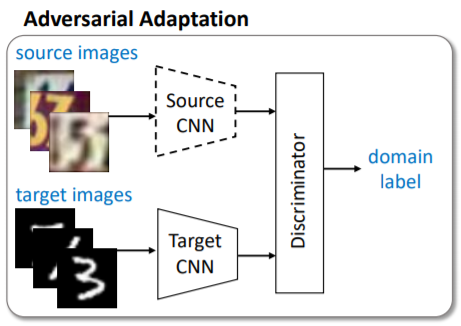

 - Source images $X_s$과 target images $X_t$로부터 domain label을 제대로 예측할 수 있도록 Discriminator $D$를 학습한다.
 - Target images $X_t$로부터 Discriminator $D$가 domain label을 제대로 예측할 수 없도록 target CNN $M_t$을 학습한다.

---

**Backpropagation**

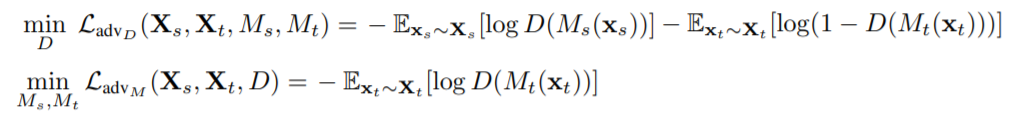


In [ ]:
def adda(src_encoder, tgt_encoder, discriminator, src_loader, tgt_loader):
    """ Adversarial adaptation for training target encoder """

    src_encoder.eval()
    set_requires_grad(src_encoder, requires_grad=False)

    # Setup criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optim_enc = optim.Adam(params=tgt_encoder.parameters(),
                           lr=args.lr_tgt_enc,
                           betas=(args.beta1, args.beta2))
    optim_dis = optim.Adam(params=discriminator.parameters(),
                           lr=args.lr_dis,
                           betas=(args.beta1, args.beta2))
    
    # Train model
    for epoch in range(1, args.epochs_adapt + 1):
        num_data = 0
        total_acc = 0.0
        total_loss_enc = 0.0
        total_loss_dis = 0.0


        for (images_src, _), (images_tgt, _) in zip(src_loader, tgt_loader):
            #===========================#
            #    Train discriminator    #
            #===========================#
            set_requires_grad(tgt_encoder, requires_grad=False)
            set_requires_grad(discriminator, requires_grad=True)

            # Load images to GPU
            images_src = load_gpu(images_src)
            images_tgt = load_gpu(images_tgt)

            # Create domain labels
            labels_dis = torch.cat([torch.ones(images_src.shape[0]),
                                    torch.zeros(images_tgt.shape[0])], 0)
            labels_dis = load_gpu(labels_dis)

            # Extract features
            features_src = src_encoder(images_src)
            features_tgt = tgt_encoder(images_tgt)
            features_concat = torch.cat([features_src, features_tgt], 0)

            # Predict domain labels and compute loss
            preds = discriminator(features_concat).squeeze()
            loss = criterion(preds, labels_dis)

            # Optimize discriminator
            optim_dis.zero_grad()
            loss.backward()
            optim_dis.step()

            # Update loss and accuracy
            num_data += len(labels_dis)
            total_acc += ((preds > 0).long() == labels_dis.long()).sum().item()
            total_loss_dis += loss.item()

        
            #===========================#
            #    Train target encoder   #
            #===========================#
            set_requires_grad(tgt_encoder, requires_grad=True)
            set_requires_grad(discriminator, requires_grad=False)

            # Load images to GPU
            images_tgt = load_gpu(images_tgt)

            # Create domain labels
            labels_enc = torch.ones(images_tgt.shape[0])
            labels_enc = load_gpu(labels_enc)

            # Predict domain labels and compute loss
            preds = discriminator(tgt_encoder(images_tgt)).squeeze()
            loss = criterion(preds, labels_enc)

            # Optimize target encoder
            optim_enc.zero_grad()
            loss.backward()
            optim_enc.step()

            # Update loss
            total_loss_enc += loss.item()
        
        loader_len = min(len(src_loader), len(tgt_loader))
        total_acc = total_acc / num_data
        total_loss_enc = total_loss_enc / loader_len
        total_loss_dis = total_loss_dis / loader_len

        # Print log information
        print('Epoch [{:3}/{:3}] : g_loss={:9.4f}, d_loss={:9.4f}, acc={:.4f}'.format(
            epoch, args.epochs_adapt, total_loss_enc, total_loss_dis, total_acc
        ))

        # Save model parameters
        if epoch % args.save_adapt == 0:
            print('\n#=========================================#\n')
            print('\tSave target model parameters\n')
            save_model(tgt_encoder, 'tgt-encoder-{}.pt'.format(epoch))
            print('\n#=========================================#\n')

    # Save final model parameters
    print('\n#=========================================#\n')
    print('\tSave target model parameters\n')
    save_model(tgt_encoder, 'tgt-encoder-final.pt')
    print('\n#=========================================#\n')

    return tgt_encoder


def set_requires_grad(model, requires_grad=True):
    """ Set requires_grad flag """

    for param in model.parameters():
        param.requires_grad = requires_grad

# Testing

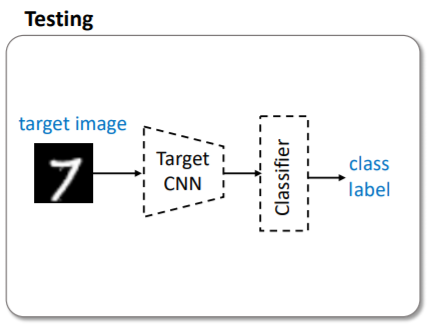

 - Target dataset $(X_t, Y_t)$으로부터 target CNN $M_t$과 classifier $C$가 class label을 제대로 예측하는지 확인한다.

In [ ]:
def test(encoder, classifier, loader):
    # Set model mode
    encoder.eval()
    classifier.eval()

    num_data = 0
    total_acc = 0.0

    # Test model
    with torch.no_grad():
        for images, labels in loader:
            # load images and labels to GPU
            images = load_gpu(images)
            labels = load_gpu(labels)

            # Predict labels and compute loss
            preds = classifier(encoder(images))

            # Update total loss and total accuracy
            num_data += len(labels)
            total_acc += (preds.max(1)[1] == labels).sum().item()

        total_acc = total_acc / num_data

    print('   - Accuracy = {:.4f}'.format(total_acc))

# Main

In [ ]:
def init_model(model):
    """ Initialize model """

    # Initialize model weight
    for module in model.modules():
        if type(module) in [nn.Conv2d, nn.Linear]:
            nn.init.xavier_normal_(module.weight)
            nn.init.zeros_(module.bias)
    
    # Load model to GPU
    model = load_gpu(model)

    return model


def load_model(model, file_name):
    """ Load model parameters """

    if not os.path.exists(os.path.join(args.model_root, file_name)):
        return model, False

    model.load_state_dict(torch.load(os.path.join(args.model_root, file_name), map_location='cuda:{}'.format(args.gpu_num)))
    return model, True


# Get source and target data loader
src_loader_train = get_mnist(True)
src_loader_test = get_mnist(False)
tgt_loader_train = get_usps(True)
tgt_loader_test = get_usps(False)

# Initialze model
src_encoder = init_model(Encoder())
tgt_encoder = init_model(Encoder())
classifier = init_model(Classifier())
discriminator = init_model(Discriminator())


print('#=========================================#\n')
print('Adversarial Discriminator Domain Adaptation\n')
print('#=========================================#\n')


#===============================#
#          Pre-training         #
#===============================#
print('#=========================================#\n')
print('\t\tPre-training\n')
print('#=========================================#\n')

# Load source model parameters
src_encoder, valid_enc = load_model(src_encoder, 'src-encoder-final.pt')
classifier, valid_cls = load_model(classifier, 'classifier-final.pt')

if not valid_enc or not valid_cls:
    src_encoder, classifier = train_src(src_encoder, classifier, src_loader_train)
print('Done!')

# Test source model performance
test_src(src_encoder, classifier, src_loader_test)


#===============================#
#     Adversarial Adaptation    #
#===============================#
print('#=========================================#\n')
print('\t  Adversarial Adaptation\n')
print('#=========================================#\n')

tgt_encoder, _ = load_model(tgt_encoder, 'src-encoder-final.pt')
tgt_encoder, valid_enc = load_model(tgt_encoder, 'tgt-encoder-final.pt')

if not valid_enc:
    tgt_encoder = adda(src_encoder, tgt_encoder, discriminator, src_loader_train, tgt_loader_train)
print('Done!')


#===============================#
#            Testing            #
#===============================#
print('\n#=========================================#\n')
print('\t\tTesting\n')
print('#=========================================#\n')

print('>> Source only\n')
test(src_encoder, classifier, tgt_loader_test)

print('\n>> ADDA\n')
test(tgt_encoder, classifier, tgt_loader_test)

  0%|          | 0/1831726 [00:00<?, ?it/s]

#=========================================#

Adversarial Discriminator Domain Adaptation

#=========================================#

#=========================================#

		Pre-training

#=========================================#

Epoch [  1/ 20] : loss=  0.7624, acc=0.7550
Epoch [  2/ 20] : loss=  0.2391, acc=0.9284
Epoch [  3/ 20] : loss=  0.1635, acc=0.9516
Epoch [  4/ 20] : loss=  0.1325, acc=0.9600
Epoch [  5/ 20] : loss=  0.1109, acc=0.9663
Epoch [  6/ 20] : loss=  0.0958, acc=0.9716
Epoch [  7/ 20] : loss=  0.0864, acc=0.9736
Epoch [  8/ 20] : loss=  0.0814, acc=0.9753
Epoch [  9/ 20] : loss=  0.0764, acc=0.9768
Epoch [ 10/ 20] : loss=  0.0697, acc=0.9785
   - Accuracy = 0.9900

#=========================================#

	Save source model parameters

  - Save model to backup/src-encoder-10.pt

  - Save model to backup/classifier-10.pt


#=========================================#

Epoch [ 11/ 20] : loss=  0.0646, acc=0.9803
Epoch [ 12/ 20] : loss=  0.0611, acc=0.981

# Visualization

 - **Source images와 target images의 distribution을 T-SNE로 차원을 감소화한 다음 시각화한다.**

 - **Input Data** : Input images $(X_s, X_t)$의 distribution 시각화한 결과이다.
 - **Source Only** : source CNN $M_s$으로부터 나온 feature vector $f$를 시각화한 결과이다.
 - **ADDA** : ADDA를 통해 학습된 target CNN $M_t$으로부터 나온 feature vector $f$를 시각화한 결과이다.



#=========================================#

	Save Input Data Distribution

  - img/mnist_usps_input.png

#=========================================#


#=========================================#

	Save Source Only Distribution

  - img/mnist_usps_source_only.png

#=========================================#


#=========================================#

	Save ADDA Distribution

  - img/mnist_usps_adda.png

#=========================================#



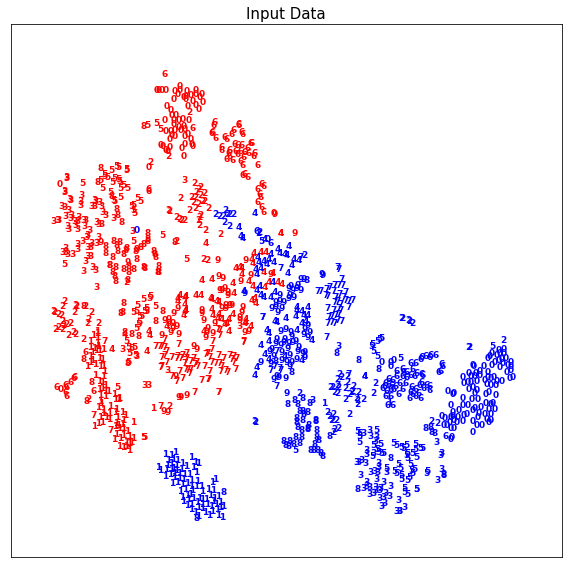

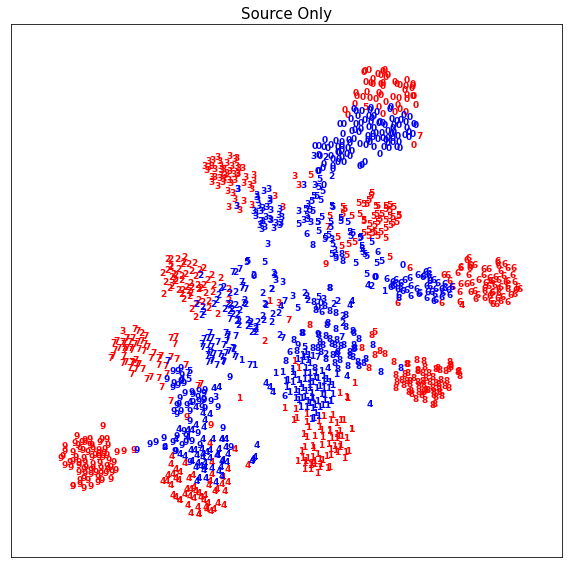

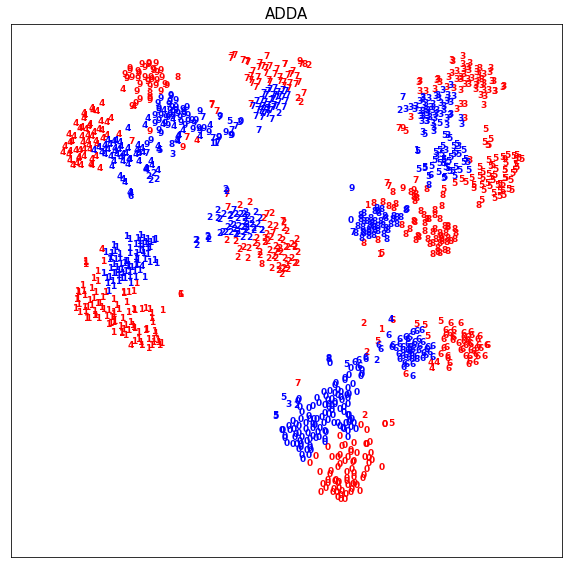

In [ ]:
def save_plot(X, y, d, mode, file_name):
    """ Save data distribution """

    # Set plot size
    plt.figure(figsize=(8, 8))

    for i in range(len(d)):
        # Get domain color
        color = (1.0, 0.0, 0.0, 1.0) if d[i] == 1 else (0.0, 0.0, 1.0, 1.0)

        plt.text(x=X[i, 0], y=X[i, 1],
                 s=str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 9})
    
    # Set plot options
    plt.xlim(X[:, 0].min() * 1.2, X[:, 0].max() * 1.2)
    plt.ylim(X[:, 1].min() * 1.2, X[:, 1].max() * 1.2)
    plt.xticks([]), plt.yticks([])
    plt.title(mode, fontsize=15)
    plt.tight_layout()

    # Make root directory for saving plots
    if not os.path.exists(args.img_root):
        os.mkdir(args.img_root)

    # Save plot
    plt.savefig(os.path.join(args.img_root, '{}.png'.format(file_name)))
    print('\n#=========================================#\n')
    print('\tSave {} Distribution\n'.format(mode))
    print('  - {}.png\n'.format(os.path.join(args.img_root, file_name)))
    print('#=========================================#\n')


def visualize_input(src_loader, tgt_loader, file_name):
    """ Visualize input data distribution that reduced dimension by T-SNE """

    # Extract sample data from source dataset
    list_src_images = torch.Tensor()
    list_src_labels = torch.Tensor()

    for idx, (images, labels) in enumerate(src_loader):
        if idx == 5:
            break

        list_src_images = torch.cat([list_src_images, images], 0)
        list_src_labels = torch.cat([list_src_labels, labels], 0)

    list_src_domain = torch.ones(list_src_images.shape[0])
    list_src_images = list_src_images.view(list_src_images.shape[0], -1)

    # Extract sample data from target dataset
    list_tgt_images = torch.Tensor()
    list_tgt_labels = torch.Tensor()

    for idx, (images, labels) in enumerate(tgt_loader):
        if idx == 5:
            break

        list_tgt_images = torch.cat([list_tgt_images, images], 0)
        list_tgt_labels = torch.cat([list_tgt_labels, labels], 0)

    list_tgt_domain = torch.zeros(list_tgt_images.shape[0])
    list_tgt_images = list_tgt_images.view(list_tgt_images.shape[0], -1)

    # Concatenate source and target data
    list_images_concat = torch.cat([list_src_images, list_tgt_images], 0).numpy()
    list_labels_concat = torch.cat([list_src_labels, list_tgt_labels], 0).int().numpy()
    list_domain_concat = torch.cat([list_src_domain, list_tgt_domain], 0).numpy()

    # Reduce dimension by T-SNE
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    adda_tsne = tsne.fit_transform(list_images_concat)

    # Save T-SNE result
    save_plot(adda_tsne, list_labels_concat, list_domain_concat, 'Input Data', file_name)


def visualize(encoder, src_loader, tgt_loader, mode, file_name):
    """ Visualize source and target data distribution that reduced demansion by T-SNE """

    # Extract sample data from source dataset
    list_src_images = torch.Tensor()
    list_src_labels = torch.Tensor()
    list_src_domain = torch.Tensor()

    for idx, (images, labels) in enumerate(src_loader):
        if idx == 5:
            break

        list_src_images = torch.cat([list_src_images, images], 0)
        list_src_labels = torch.cat([list_src_labels, labels], 0)

    list_src_domain = torch.ones(list_src_images.shape[0])

    # Extract sample data from target dataset
    list_tgt_images = torch.Tensor()
    list_tgt_labels = torch.Tensor()
    list_tgt_domain = torch.Tensor()

    for idx, (images, labels) in enumerate(tgt_loader):
        if idx == 5:
            break

        list_tgt_images = torch.cat([list_tgt_images, images], 0)
        list_tgt_labels = torch.cat([list_tgt_labels, labels], 0)

    list_tgt_domain = torch.zeros(list_tgt_images.shape[0])

    # Concatenate source and target data
    list_images_concat = torch.cat([list_src_images, list_tgt_images], 0)
    list_labels_concat = torch.cat([list_src_labels, list_tgt_labels], 0).int().numpy()
    list_domain_concat = torch.cat([list_src_domain, list_tgt_domain], 0).numpy()

    # Extract features
    list_images_concat = load_gpu(list_images_concat)
    list_features = encoder(list_images_concat).detach().cpu().numpy()

    # Reduce dimension by T-SNE
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
    adda_tsne = tsne.fit_transform(list_features)

    # Save T-SNE result
    save_plot(adda_tsne, list_labels_concat, list_domain_concat, mode, file_name)


# Visualize input data distribution
visualize_input(src_loader_test, tgt_loader_test, 'mnist_usps_input')

# Visualize data distribution by trained source only
encoder = init_model(Encoder())
encoder, _ = load_model(encoder, 'src-encoder-final.pt')
visualize(encoder, src_loader_test, tgt_loader_test, 'Source Only', 'mnist_usps_source_only')

# Visualize data distribution by trained ADDA
encoder, _ = load_model(encoder, 'tgt-encoder-final.pt')
visualize(encoder, src_loader_test, tgt_loader_test, 'ADDA', 'mnist_usps_adda')